In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time
# from labellines import labelLine, labelLines

In [58]:
# interval of solution and number of steps
ri, rf, dr = 0, 20, 0.001
steps = int((rf - ri)//dr)
rinterv = np.linspace(ri, rf, steps, endpoint=True)

# EM Gaussian profile, emparams in the format [scale, center, size] = [A, r0, delta_r] from Eq. (36) in my "Notes on Axion Stars"
def em_prfl(r, emparams):
    return emparams[0]*np.exp(-np.power((r - emparams[1])/emparams[2],2)/2)

# Right-hand side of ODEs from Eq. (35) in my "Notes on Axion Stars", here X = [\tilde{\Psi}, \chi, \tilde{\phi}, \xi]
def f(r, X, emparams):
    f1 = X[1]
    f2 = -2*X[1]/r + 2*X[2]*X[0] - em_prfl(r, emparams)
    f3 = X[3]
    f4 = -2*X[3]/r + np.power(X[0],2)
    return np.array([f1, f2, f3, f4])

# Single step of RK4
def rk4step(r, X, emparams):
    k1 = dr*f(r, X, emparams)
    k2 = dr*f(r + dr/2, X + k1/2, emparams)
    k3 = dr*f(r + dr/2, X + k2/2, emparams)
    k4 = dr*f(r + dr, X + k3, emparams)
    return X + (k1 + 2*k2 + 2*k3 + k4)/6

# Full RK4
def rk4(Xbc, emparams):
    # Initialize the arrays
    Xs = np.zeros((4, steps))

    # Boundary conditions at r = ri
    Xs[..., 0] = Xbc

    # Perform RK4
    bpoint = 0
    for step in np.arange(1, steps):
        rnow = rinterv[step]
        Xs[..., step] = rk4step(rnow, Xs[..., step - 1], emparams)
    
        # The breakpoint 'bpoint' occurs when the solution stops converging to zero at r -> infty
        if Xs[..., step][0] > Xs[..., step - 1][0] or Xs[..., step][0] < 0:
            bpoint = step
            return Xs, bpoint

    return Xs, bpoint

# Step of Monte Carlo for shooting method
def mc_step(phi0, bpointold, emparams):
    Xbc_step = np.array([1, 0, phi0, 0])
    Xs_step, bpoint = rk4(Xbc_step, emparams)

    # If the breakpoint happens for higher values of r, keep the new solution
    if bpoint > bpointold:
        return True, bpoint
    elif bpoint <= bpointold:
        return False, bpointold

# Full Monte Carlo
def find_sol(emparams):
    bpoint = 0
    phi0 = np.random.uniform(-1,0)

    nsteps = 5000
    count, step_stdev = 0, 1
    for i in np.arange(nsteps):
        # Give a random kick to phi0
        phi0old = phi0
        phi0 += np.random.normal(0,step_stdev)

        mcs = mc_step(phi0, bpoint, emparams)
        if mcs[0]:  # If a larger 'bpoint' is found, keep
            bpoint = mcs[1]
        else:   # If not, back to old valur of phi0
            phi0 = phi0old
            count += 1
        
        # Variable 'count' avoids the code 'getting stuck' for large periods of time, makes step smaller when it happens
        if count > 100:
            count = 0
            step_stdev = step_stdev/10

        # If the solution does not break in the interval or step is too small, stop
        if bpoint == steps - 1 or step_stdev < 1e-20:
            return phi0, bpoint

    return phi0, bpoint

# Asymptotic behavior of phi
def fit_asymp(r, C, epsilonb):
        return C/r + epsilonb

def find_epsilonb(rinterv_loc, Xs):
    # Find epsilonb from asymptotic behavior of phi
    tail_ini = 100
    r_asymp, phi_asymp = rinterv_loc[-tail_ini:-1], Xs[2].T[-tail_ini:-1]
    popt, pcov = curve_fit(fit_asymp, r_asymp, phi_asymp)
    # The error from the fit is epsilonb_stdev
    epsilonb, epsilonb_stdev = popt[1], np.sqrt(np.diag(pcov))[1] 
    return epsilonb, epsilonb_stdev

The value of epsilonb is: 0.6889066964156552
The value of tilde phi0 is: -0.6471443334660724


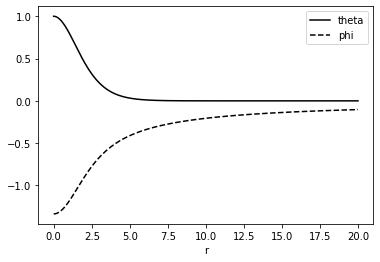

In [24]:
# Plotting solution
emparams = [0.1, 0, 0.1] # emparams in the format [scale, center, size]
phi0_plt = find_sol(emparams)[0]
Xbc_plt = np.array([1, 0, phi0_plt, 0])
Xs, bpoint = rk4(Xbc_plt, emparams)
rinterv_cut, Xs = rinterv[:bpoint], Xs[:, :bpoint]

epsilonb = find_epsilonb(rinterv_cut, Xs)[0]
print('The value of epsilonb is:', epsilonb)
print('The value of tilde phi0 is:', Xs[2].T[0])

plt.plot(rinterv_cut, Xs[0].T, 'k-', label = "theta")
plt.plot(rinterv_cut, Xs[2].T - epsilonb, 'k--', label = "phi")
plt.xlabel("r")
plt.legend();

In [80]:
# Finding solutions, emparams in the format [scale = 1, center = 0, size = 0.1]
scales = np.linspace(0, 100, 101, endpoint=True)[1:]
size_choice = 0.01

start_time = time.time()
thetas, phis, epsilonbs = [], [], []
for scale in scales:
    emparams = [scale, 0, size_choice]
    phi0_plt = find_sol(emparams)[0]
    Xbc_plt = np.array([1, 0, phi0_plt, 0])
    Xs, bpoint = rk4(Xbc_plt, emparams)
    rinterv_cut, Xs = rinterv[:bpoint], Xs[:, :bpoint]

    thetas.append(np.array(list(zip(rinterv_cut, Xs[0].T))))
    phis.append(np.array(list(zip(rinterv_cut, Xs[2].T))))

    epsilonb = find_epsilonb(rinterv_cut, Xs)[0]
    epsilonbs.append(epsilonb)
    print('Found solution for emparams = ', emparams, '. It took ', np.round((time.time() - start_time)/60, 2), ' minutes.')
    start_time = time.time()

Found solution for emparams =  [1.0, 0, 0.01] . It took  20.23  minutes.
Found solution for emparams =  [2.0, 0, 0.01] . It took  20.25  minutes.
Found solution for emparams =  [3.0, 0, 0.01] . It took  20.56  minutes.
Found solution for emparams =  [4.0, 0, 0.01] . It took  20.51  minutes.
Found solution for emparams =  [5.0, 0, 0.01] . It took  20.43  minutes.
Found solution for emparams =  [6.0, 0, 0.01] . It took  20.57  minutes.
Found solution for emparams =  [7.0, 0, 0.01] . It took  21.57  minutes.
Found solution for emparams =  [8.0, 0, 0.01] . It took  20.15  minutes.
Found solution for emparams =  [9.0, 0, 0.01] . It took  19.77  minutes.
Found solution for emparams =  [10.0, 0, 0.01] . It took  19.81  minutes.
Found solution for emparams =  [11.0, 0, 0.01] . It took  19.72  minutes.
Found solution for emparams =  [12.0, 0, 0.01] . It took  19.8  minutes.
Found solution for emparams =  [13.0, 0, 0.01] . It took  19.74  minutes.
Found solution for emparams =  [14.0, 0, 0.01] .

KeyboardInterrupt: 

In [88]:
# Save data
np.savez("output/bump_s_0_0dot01.npz", phis = phis, thetas = thetas, epsilonbs = epsilonbs, scales = scales)

# Load saved data
data = np.load("output/bump_s_0_0dot01.npz", allow_pickle=True)
thetas, phis, epsilonbs, scales = data['thetas'], data['phis'], data['epsilonbs'], data['scales']

C:\Users\gsali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


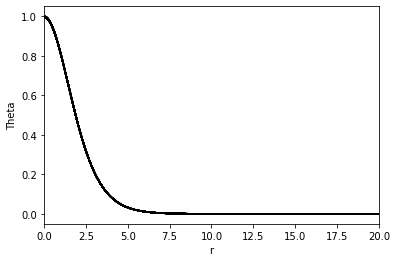

In [89]:
# Plotting the solutions
for i, theta in enumerate(thetas):
    if scales[i] == 0:
        plt.plot(theta.T[0], theta.T[1], color = 'red', label = str(scales[i]))
    else:
        plt.plot(theta.T[0], theta.T[1], color = 'black', label = str(scales[i]))
plt.xlabel("r")
plt.ylabel('Theta')
plt.xlim(left = 0, right = 20);

# xvals = []
# labelLines(plt.gca().get_lines(),  align=False);

Text(0, 0.5, 'epsilonb')

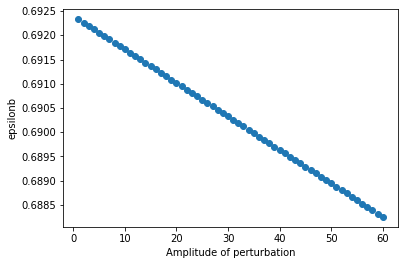

In [90]:
plt.scatter(scales[:60],epsilonbs)
plt.xlabel('Amplitude of perturbation')
plt.ylabel('epsilonb')

Text(0, 0.5, 'Phi')

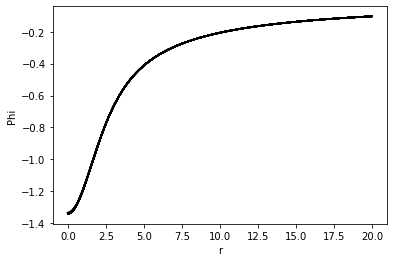

In [91]:
# Plotting the potentials, emparams in the format [scale, center = 0, size = 1]
for i, phi in enumerate(phis):
    plt.plot(phi.T[0], phi.T[1] - epsilonbs[i], color = 'black', label = str(scales[i]))
plt.xlabel("r")
plt.ylabel('Phi')

# xvals = [1,1,1,1]
# labelLines(plt.gca().get_lines(), xvals = xvals, align=False);